In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
#import cython
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [3]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"

In [4]:
# our modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP
from lace.emulator import poly_p1d
from lace.emulator import pd_archive


 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:210: SyntaxWarning:"is" with a literal. Did you mean "=="?
 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:210: SyntaxWarning:"is" with a literal. Did you mean "=="?


In [5]:
import os
env_var = os.environ
os.environ["LACE_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE"
os.environ["LACE_MANAGER_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE_manager"

In [6]:
import os
env_var = os.environ
os.environ["LACE_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE"
basedir="../LaCE_manager/LaCE/lace/emulator/sim_suites/Australia20/"
basedir_test="/LaCE/lace/emulator/sim_suites/Australia20/"

In [7]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [8]:
def sigma68(data): return 0.5*(np.nanquantile(data,q = 0.84,axis = 0) - np.nanquantile(data,q = 0.16,axis = 0))

In [9]:
drop_tau_rescalings = False
emu_params = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
emu_label = ['p1d_Mpc']
emu_kmax_Mpc=8
kmax_Mpc_train=4
kmax_Mpc_test=4
zmax = 4.5
Nsim=30

In [10]:
sim=pd_archive.archivePD()

key_to_extract = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']

training_data = [{ key:value for key,value in sim.data[i].items() if key in key_to_extract} for i in range(len(sim.data))]
training_data = [list(training_data[i].values()) for i in range(len(sim.data))]
training_data = np.array(training_data)

min_ = training_data.min(0)
max_ = training_data.max(0)

mean_params, std_params = training_data.mean(0), training_data.std(0)

paramlims = np.concatenate((min_.reshape(len(min_),1),max_.reshape(len(max_),1)),1)

## DEFINE THE NETWORKS

In [12]:
class MDNemulator_polyfit(torch.nn.Module):
    def __init__(self, nhidden, ndeg):
        super().__init__()
        self.inputlay = torch.nn.Sequential(nn.Linear(6 ,10),nn.LeakyReLU(0.5))
        
        params = np.linspace(10,100,nhidden)
        modules = []
        for k in range(nhidden-1):
            modules.append(nn.Linear(int(params[k]) ,int(params[k+1])))
            modules.append(nn.LeakyReLU(0.5))  
        self.hiddenlay = nn.Sequential(*modules)
                
        self.means = torch.nn.Sequential(nn.Linear(100 ,50),nn.LeakyReLU(0.5),nn.Linear(50, ndeg+1))
        self.stds = torch.nn.Sequential(nn.Linear(100 ,50),nn.LeakyReLU(0.5),nn.Linear(50 ,ndeg+1))
        
    def forward(self, inp):
        
        x = self.inputlay(inp)
        x = self.hiddenlay(x)
        p1d = self.means(x)
        logerrp1d = self.stds(x)

        
        return p1d,logerrp1d   

In [13]:
class MDNemulator_polyfit_Relu(torch.nn.Module):
    def __init__(self, nhidden, ndeg):
        super().__init__()
        self.inputlay = torch.nn.Sequential(nn.Linear(6 ,10),nn.ReLU())
        
        params = np.linspace(10,100,nhidden)
        modules = []
        for k in range(nhidden-1):
            modules.append(nn.Linear(int(params[k]) ,int(params[k+1])))
            modules.append(nn.ReLU())  
        self.hiddenlay = nn.Sequential(*modules)
                
        self.means = torch.nn.Sequential(nn.Linear(100 ,50),nn.ReLU(),nn.Linear(50, ndeg+1))
        self.stds = torch.nn.Sequential(nn.Linear(100 ,50),nn.ReLU(),nn.Linear(50 ,ndeg+1))
        
    def forward(self, inp):
        
        x = self.inputlay(inp)
        x = self.hiddenlay(x)
        p1d = self.means(x)
        logerrp1d = self.stds(x)

        
        return p1d,logerrp1d   

## DEFINE THE ARCHIVE

In [14]:
# Set up cosmology to get eBOSS k_max at each z where we have data
cosmo_fid=camb_cosmo.get_cosmology()

In [15]:
# read eBOSS P1D to plot relative error bars
from lace_manager.data import data_Chabanier2019

chab=data_Chabanier2019.P1D_Chabanier2019()

In [16]:
# load one of the simulations (#0) to figure out redshift range and wavenumbers
sim=p1d_archive.archiveP1D(basedir=basedir,z_max=zmax,pick_sim_number=0,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)
# get redshifts in simulation
sim_zs=[data['z'] for data in sim.data]
Nz=len(sim_zs)
print('will use {} redshifts / snapshots'.format(Nz))
# get wavenumbers in 1/Mpc units (same for all snapshots in all sims)
sim_k_Mpc=sim.data[0]['k_Mpc']
# use only 0 < k < kmax_Mpc
k_mask=(sim_k_Mpc<kmax_Mpc_train) & (sim_k_Mpc>0)
sim_k_Mpc=sim_k_Mpc[k_mask]
Nk=42#len(sim_k_Mpc)
print('will use {} wavenumbers'.format(Nk))

will use 11 redshifts / snapshots
will use 42 wavenumbers


## TRAINING AND TEST FUNCTIONS (WITH OPTIONS TO TEST)

In [17]:
def train_mdn_polyfit(net, loader, k_mpc, epochs, step_size, lr0, polylog=True):
    optimizer = optim.Adam(net.parameters(), lr=lr0, weight_decay=1e-2)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
    ndeg=5
    if polylog==True:
        log_KMpc = torch.log10(k_mpc).cuda()
    else: 
        log_KMpc=k_mpc.cuda()
        
    for epoch in range(100):
        for datain, p1D_true in loader:
            optimizer.zero_grad() 


            coeffsPred,coeffs_logerr = net(datain.cuda())#
            coeffs_logerr = torch.clamp(coeffs_logerr,-10,5)
            coeffserr = torch.exp(coeffs_logerr)**2


            powers = torch.arange(0,ndeg+1,1).cuda()
            P1Dpred = torch.sum(coeffsPred[:,powers,None] * (log_KMpc[None,:] ** powers[None,:,None]), axis=1)


            powers_err = torch.arange(0, ndeg*2+1, 2).cuda()
            P1Derr = torch.sqrt(torch.sum(coeffserr[:,powers,None] * (log_KMpc[None,:] ** powers_err[None,:,None]), axis=1))

            P1Dlogerr = torch.log(P1Derr)


            log_prob = ((P1Dpred - p1D_true.cuda()) / P1Derr).pow(2) + 2*P1Dlogerr#

            loss = torch.nansum(log_prob,1)
            loss = torch.nanmean(loss,0)

            loss.backward()
            optimizer.step()

        scheduler.step()

    return net

In [18]:
def test_sim(truth, mdnemu, yscalings, p1dscaling,inputscaling, polylog=True):
    Nz, Nk, ndeg = 11, 42, 5
    fractional_error=np.zeros((Nz,Nk))
    emu_p1derrs=np.zeros((Nz,Nk))
    emu_p1ds = np.zeros((Nz,Nk))
    true_p1ds=np.zeros((Nz,Nk))
    
    sim_zs=truth.zs

    
    with torch.no_grad():
        # for each entry (z) in truth/test simulation, compute residuals
        for aa,item in enumerate(truth.data):

            # figure out redshift for this entry
            z=item["z"]
            # true p1d (some sims have an extra k bin, so we need to define mask again)
            true_k=item["k_Mpc"]
            k_mask=(true_k<kmax_Mpc_test) & (true_k>0)
            true_p1d=item["p1d_Mpc"][k_mask][:Nk]
            assert len(true_p1d)==Nk
            true_k = true_k[k_mask]

            fit_p1d = poly_p1d.PolyP1D(true_k,true_p1d, kmin_Mpc=1.e-3,kmax_Mpc=3,deg=5)
            true_p1d = fit_p1d.P_Mpc(true_k)


            if polylog==True:
                log_KMpc = torch.log10(torch.Tensor(true_k)).cuda()
            else:
                log_KMpc = torch.Tensor(true_k).cuda()

            # for each entry, figure emulator parameter describing it (labels)
            emu_call={}
            for param in ['Delta2_p', 'n_p', 'mF','gamma','sigT_Mpc' , 'kF_Mpc']:
                emu_call[param]=item[param]


            emu_call = list(emu_call.values())
            emu_call = np.array(emu_call)

            if inputscaling== True:
                emu_call = (emu_call - paramlims[:,0]) / (paramlims[:,1] - paramlims[:,0]) -0.5
            else: 
                emu_call = (emu_call - paramlims[:,0]) / (paramlims[:,1] - paramlims[:,0]) 

            emu_call = torch.Tensor(emu_call).unsqueeze(0)

            # ask emulator to emulate P1D (and its uncertainty)
            coeffsPred,coeffs_logerr = mdnemu(emu_call.cuda())
            coeffs_logerr = torch.clamp(coeffs_logerr,-10,5)

            coeffserr = torch.exp(coeffs_logerr)**2
            
                
            powers = torch.arange(0,ndeg+1,1).cuda()
            emu_p1d = torch.sum(coeffsPred[:,powers,None] * (log_KMpc[None,:] ** powers[None,:,None]), axis=1)


            powers_err = torch.arange(0, ndeg*2+1, 2).cuda()
            emu_p1derr = torch.sqrt(torch.sum(coeffserr[:,powers,None] * (log_KMpc[None,:] ** powers_err[None,:,None]), axis=1))


            emu_p1d = emu_p1d.detach().cpu().numpy().flatten()
            emu_p1derr = emu_p1derr.detach().cpu().numpy().flatten()


            if p1dscaling==True:
                emu_p1derr = 10**(emu_p1d)*np.log(10)*yscalings*emu_p1derr
                emu_p1d = 10**(emu_p1d) * yscalings

            else:
                emu_p1derr = emu_p1d * yscalings
                emu_p1d = emu_p1d * yscalings

            fractional_error[aa]=emu_p1d/true_p1d
            emu_p1derrs[aa]=emu_p1derr
            emu_p1ds[aa]=emu_p1d
            true_p1ds[aa]=true_p1d
            

        print('Mean fractional error:', fractional_error.mean())
        print('Std fractional error:', fractional_error.std())


    return fractional_error, emu_p1ds, true_p1ds

In [19]:
def test_othersim(truth, mdnemu, yscalings, p1dscaling,inputscaling, polylog=True):
    Nz, Nk, ndeg= 11, 42, 5
    fractional_error=np.zeros((Nz,Nk))
    emu_p1derrs=np.zeros((Nz,Nk))
    emu_p1ds = np.zeros((Nz,Nk))
    true_p1ds=np.zeros((Nz,Nk))
    
    
    with torch.no_grad():
        # for each entry (z) in truth/test simulation, compute residuals
        for aa, z in enumerate(sim_zs):

            true_k=truth[aa]['k_Mpc']
            k_mask=(true_k<kmax_Mpc_test) & (true_k>0)
            true_p1d=truth[aa]['p1d_Mpc'][k_mask][:Nk]
            assert len(true_p1d)==Nk
            true_k = true_k[k_mask]

            fit_p1d = poly_p1d.PolyP1D(true_k,true_p1d, kmin_Mpc=1.e-3,kmax_Mpc=3,deg=5)
            true_p1d = fit_p1d.P_Mpc(true_k)


            if polylog==True:
                log_KMpc = torch.log10(torch.Tensor(true_k)).cuda()
            else:
                log_KMpc = torch.Tensor(true_k).cuda()

            # for each entry, figure emulator parameter describing it (labels)
            emu_call={}
            for param in ['Delta2_p', 'n_p', 'mF','gamma','sigT_Mpc' , 'kF_Mpc']:
                emu_call[param]=truth[aa][param]


            emu_call = list(emu_call.values())
            emu_call = np.array(emu_call)

            if inputscaling== True:
                emu_call = (emu_call - paramlims[:,0]) / (paramlims[:,1] - paramlims[:,0]) -0.5
            else: 
                emu_call = (emu_call - paramlims[:,0]) / (paramlims[:,1] - paramlims[:,0]) 

            emu_call = torch.Tensor(emu_call).unsqueeze(0)

            # ask emulator to emulate P1D (and its uncertainty)
            coeffsPred,coeffs_logerr = mdnemu(emu_call.cuda())
            coeffs_logerr = torch.clamp(coeffs_logerr,-10,5)

            coeffserr = torch.exp(coeffs_logerr)**2
                            
            powers = torch.arange(0,ndeg+1,1).cuda()
            emu_p1d = torch.sum(coeffsPred[:,powers,None] * (log_KMpc[None,:] ** powers[None,:,None]), axis=1)


            powers_err = torch.arange(0, ndeg*2+1, 2).cuda()
            emu_p1derr = torch.sqrt(torch.sum(coeffserr[:,powers,None] * (log_KMpc[None,:] ** powers_err[None,:,None]), axis=1))


            emu_p1d = emu_p1d.detach().cpu().numpy().flatten()
            emu_p1derr = emu_p1derr.detach().cpu().numpy().flatten()

            if p1dscaling==True:
                emu_p1derr = 10**(emu_p1d)*np.log(10)*yscalings*emu_p1derr
                emu_p1d = 10**(emu_p1d) * yscalings

            else:
                emu_p1derr = emu_p1d * yscalings
                emu_p1d = emu_p1d * yscalings

            fractional_error[aa]=emu_p1d/true_p1d
            emu_p1derrs[aa]=emu_p1derr
            emu_p1ds[aa]=emu_p1d
            true_p1ds[aa]=true_p1d
            

        print('Mean fractional error:', fractional_error.mean())
        print('Std fractional error:', fractional_error.std())


    return fractional_error, emu_p1ds, true_p1ds

## DATA SELECTION (WITH SCALING OPTIONS)

In [20]:
def get_training_pd1(training, key='mean', test_scaling=False):
    
    if key=='mean':
        key_to_extract = ['p1d_Mpc']
    if key=='plus':
        key_to_extract = ['p1d_Mpc_plus']
    if key=='minus':
        key_to_extract = ['p1d_Mpc_minus']
        
    training_label = [{ key:value for key,value in training.data[i].items() if key in key_to_extract} for i in range(len(training.data))]
    training_label = [list(training_label[i].values())[0][1:(Nk+1)].tolist() for i in range(len(training.data))]
    training_label = np.array(training_label)

    yscalings = np.median(training_label)
    #training_label = training_label/yscalings

    if test_scaling==True:
        training_label = np.log10(training_label / yscalings)
    else:
        training_label = training_label / yscalings
        
    training_label = torch.Tensor(training_label)
    
    return training_label,yscalings

In [21]:
def get_training_kMpc(training):
    key_to_extract = ['k_Mpc']
    training_k = [{ key:value for key,value in training.data[i].items() if key in key_to_extract} for i in range(len(training.data))]
    training_k = [list(training_k[i].values())[0][1:(Nk+1)].tolist() for i in range(len(training.data))]
    training_k = np.array(training_k)[0,:]
    training_k = torch.Tensor(training_k)
    
    return training_k

In [26]:
def get_training_data(training,paramlims, key='mean', test_scaling=False):
    
    if key=='mean':
        key_to_extract = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
    elif key=='plus':
        key_to_extract = ['Delta2_p', 'n_p','mF_plus', 'sigT_Mpc_plus', 'gamma_plus', 'kF_Mpc_plus']
    elif key=='minus':
        key_to_extract = ['Delta2_p', 'n_p','mF_minus', 'sigT_Mpc_minus', 'gamma_minus', 'kF_Mpc_minus']

    training_data = [{ key:value for key,value in training.data[i].items() if key in key_to_extract} for i in range(len(training.data))]
    training_data = [list(training_data[i].values()) for i in range(len(training.data))]
    training_data = np.array(training_data)
    
    print(training_data.shape)
    

    if test_scaling==True:
        training_data = (training_data - paramlims[:,0]) / (paramlims[:,1] - paramlims[:,0]) - 0.5
    else:
        training_data = (training_data - paramlims[:,0]) / (paramlims[:,1] - paramlims[:,0]) 
    
    training_data = torch.Tensor(training_data)
    
    return training_data

In [27]:
from lace_manager.emulator import test_simulation
basedir_test="/LaCE/lace/emulator/sim_suites/Australia20/"
#truth=test_simulation.TestSimulation(basedir=basedir_test,sim_label='diffSeed',z_max=zmax)
truth=pd_archive.archivePD(z_max=4.5,nsamples=30, pick_sim='central')
truth.average_over_samples(flag="all")
zs = [d['z'] for d in truth.data_av_all if d['scale_tau'] == 1] 
truth = [d for d in truth.data_av_all if d['scale_tau'] == 1] 
# archive containing all other simulations
training=pd_archive.archivePD()


In [28]:
def test_characteristics(p1dscaling, inputscaling, add_plusminus, Lrelu, polylog):

    training_data = get_training_data(training,paramlims, key='mean',test_scaling=inputscaling)
    training_label, yscalings = get_training_pd1(training, test_scaling = p1dscaling)
        
    training_k = get_training_kMpc(training)
                
    data_training = TensorDataset(training_data,training_label)
    loader_train = DataLoader(data_training, batch_size=100, shuffle = True)
    
    initial_weights=torch.load('initial_weights.pt', map_location='cpu')
    
    if Lrelu == True:
        mdnemu = MDNemulator_polyfit(5,5).cuda()
    else:
        mdnemu = MDNemulator_polyfit_Relu(5,5).cuda()    
    mdnemu.load_state_dict(initial_weights)
    mdnemu = train_mdn_polyfit(mdnemu, loader_train, training_k, epochs=800, step_size=600, lr0=1e-3, polylog=polylog)#300 250
    mdnemu = mdnemu.eval()
    
    fractional_error, emu_p1ds, true_p1ds = test_othersim(truth, mdnemu, yscalings, p1dscaling, inputscaling, polylog)
    
    return fractional_error, emu_p1ds, true_p1ds

In [46]:
fractional_error_null, emu_p1ds_null, true_p1ds_null= test_characteristics(p1dscaling=False, inputscaling=False, add_plusminus=False, Lrelu=False, polylog=False)


(10230, 6)
Mean fractional error: -1.9055098543500077
Std fractional error: 7.148749745569881


In [30]:
fractional_error_polylog, emu_p1ds_polylog, true_p1ds_polylog = test_characteristics(p1dscaling=False, inputscaling=False, add_plusminus=False, Lrelu=False, polylog=True)


(10230, 6)
Mean fractional error: 0.9778263962757139
Std fractional error: 0.014721733881398327


In [31]:
fractional_error_p1dscaling, emu_p1ds_p1dscaling, true_p1ds_p1dscaling = test_characteristics(p1dscaling=True, inputscaling=False, add_plusminus=False, Lrelu=False, polylog=True)


(10230, 6)
Mean fractional error: 1.0030818379586883
Std fractional error: 0.006972147780864874


In [69]:
fractional_error_inpscaling, emu_p1ds_inpscaling, true_p1ds_inpscaling = test_characteristics(p1dscaling=False, inputscaling=True, add_plusminus=False, Lrelu=False, polylog=True)


(10230, 6)
Mean fractional error: 1.0041623747371609
Std fractional error: 0.007549314217830967


In [27]:
fractional_error_plusminus, emu_p1ds_plusminus, true_p1ds_plusminus = test_characteristics(p1dscaling=False, inputscaling=False, add_plusminus=True, Lrelu=False, polylog=True)


Mean fractional error: 1.0048457377846427
Std fractional error: 0.007593110494589896


In [59]:
fractional_error_lrelu, emu_p1ds_lrelu, true_p1ds_lrelu = test_characteristics(p1dscaling=False, inputscaling=False, add_plusminus=False, Lrelu=True, polylog=True)


(10230, 6)
Mean fractional error: 0.9952462345135736
Std fractional error: 0.007176610129576123


In [49]:
fractional_error_p1dscal_lr, emu_p1ds_p1dscal_lr, true_p1ds_p1dscal_lr = test_characteristics(p1dscaling=True, inputscaling=False, add_plusminus=False, Lrelu=True, polylog=True)


(10230, 6)
Mean fractional error: 0.9966548735771699
Std fractional error: 0.005211897137773379


In [52]:
fractional_error_p1dscal_lr_inpscaling, emu_p1ds_p1dscal_lr_inpscaling, true_p1ds_p1dscal_lr_inpscaling = test_characteristics(p1dscaling=True, inputscaling=True, add_plusminus=False, Lrelu=True, polylog=True)


(10230, 6)
Mean fractional error: 0.9867464417538849
Std fractional error: 0.004572048238030912


In [36]:
fractional_error_p1dscal_lr_inpscaling_plusmin, emu_p1ds_p1dscal_lr_inpscaling_plusmin, true_p1ds_p1dscal_lr_inpscaling_plusmin = test_characteristics(p1dscaling=True, inputscaling=True, add_plusminus=True, Lrelu=True, polylog=True)


(10230, 6)
Mean fractional error: 1.0055812407287767
Std fractional error: 0.007034336138181418


In [43]:
np.std((fractional_error_polylog-1)*100)

1.4721733881398327

In [72]:
labels = [r'$P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot k$',r'$P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$',r'$\log P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$',r'$P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$ + LeakyReLU', r'$P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$ + Param. shift', r'$\log P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$ + LeakyReLU',  r'$\log P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$ + LeakyReLU + Param. shift']

values = [np.std((fractional_error_null-1)*100),np.std((fractional_error_polylog-1)*100),np.std((fractional_error_p1dscaling-1)*100),np.std((fractional_error_lrelu-1)*100), np.std((fractional_error_inpscaling-1)*100), np.std((fractional_error_p1dscal_lr-1)*100), np.std((fractional_error_p1dscal_lr_inpscaling-1)*100) ]
#values = [np.std(fractional_error_null),np.std(fractional_error_polylog),np.std(fractional_error_p1dscaling),np.std(fractional_error_lrelu), np.std(fractional_error_inpscaling), np.std(fractional_error_p1dscal_lr), np.std(fractional_error_p1dscal_lr_inpscaling) ]

labels = [r'$P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot k_{\parallel}$','A','A+B','A+C', 'A+D', 'A+B+C',  'A+B+C+D',]



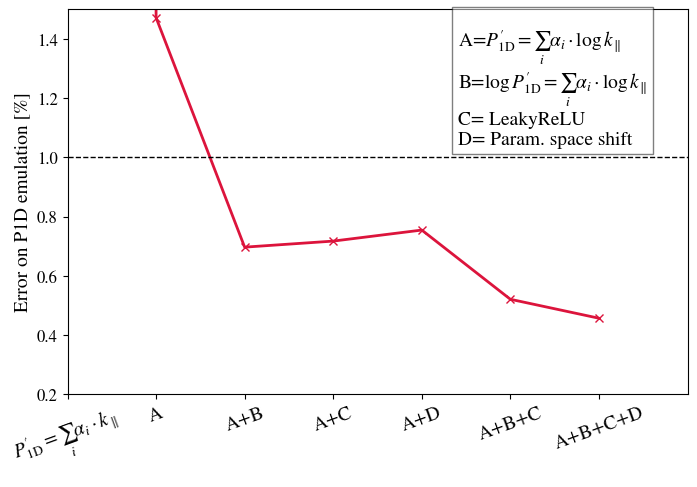

In [73]:
plt.figure(figsize = (8,5))
plt.plot(labels, values, marker = 'x', color = 'crimson', ls = '-', lw = 2)


plt.yticks(fontsize = 12)
plt.xticks(rotation =20, fontsize = 14)

plt.ylabel('Error on P1D emulation [%]', fontsize = 14)

plt.axhline(y =1, color = 'black', lw = 1, ls='--')


info_text = r'A=$P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k_{\parallel}$\nB=$\log P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k_{\parallel}$\nC= LeakyReLU\nD= Param. space shift'
info_text = info_text.replace(r'\n', '\n')
#info_text = 'A = Polyfit-log\nB = log(P1D)\nC = LeakyReLU\nD = Param. space shift'
plt.text(0.63, 0.65, info_text, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize = 14)


plt.xlim(0,7)
#plt.yscale('log')
plt.ylim(0.2,1.5)

plt.savefig('net_characterisation.pdf', bbox_inches = 'tight')

In [67]:
info_text = r'A=$P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$\nB=$\log P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$\nC= LeakyReLU\nD= Param. space shift'
info_text = info_text.replace(r'\n', '\n')
print(info_text)

A=$P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$
B=$\log P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$
C= LeakyReLU
D= Param. space shift


In [13]:
#fractional_error_gp_1axis = np.loadtxt('notebooks_tests/fractional_error_gp.txt').reshape(30,11,32)
fractional_error_3axis_all = np.loadtxt('fractional_errors/3_axes_scalings/fractional_error_avgall.txt').reshape(30,11,32) #average axes
fractional_error_3axis_axes = np.loadtxt('fractional_errors/3_axes/fractional_error_3axes_axes.txt').reshape(30,11,32) #average axes
fractional_error_3axis_phases = np.loadtxt('fractional_errors/3_axes/fractional_error_3axes_phases.txt').reshape(30,11,32) #average axes
fractional_error_3axis_axesphases = np.loadtxt('fractional_errors/3_axes/fractional_error_3axes_phasesaxes.txt').reshape(30,11,32) #average axes

fractional_error_3axis_axesphases_newresc = np.loadtxt('fractional_errors/3_axes/fractional_error_3axes_newscaling.txt').reshape(30,11,32) #average axes


fractional_error_3axis_allnone = np.loadtxt('fractional_errors/3_axes/fractional_error_3axes_allnone.txt').reshape(30,11,32) #average axes


fractional_error_3axis_axesphasesnone = np.loadtxt('fractional_errors/3_axes/fractional_error_3axes_phasesaxesnone.txt').reshape(30,11,32) #average axes


In [14]:
sigma68(fractional_error_3axis_axesphases.flatten()), sigma68(fractional_error_3axis_axesphases_newresc.flatten())

(0.008827779809512992, 0.00997585088244679)

In [15]:
fractional_error_1axis = (fractional_error_1axis -1 )*100
#fractional_error_gp_1axis = (fractional_error_gp_1axis-1)*100
fractional_error_3axes_1a = (fractional_error_3axes_1a-1)*100
fractional_error_1a_3a = (fractional_error_1a_3a-1)*100


fractional_error_3axis_all = (fractional_error_3axis_all - 1) *100
fractional_error_3axis_axes = (fractional_error_3axis_axes -1 )*100
fractional_error_3axis_phases = (fractional_error_3axis_phases -1 )*100
fractional_error_3axis_axesphases = (fractional_error_3axis_axesphases -1 )*100
fractional_error_3axis_allnone = (fractional_error_3axis_allnone -1 )*100

fractional_error_3axis_axesphasesnone = (fractional_error_3axis_axesphasesnone-1)*100

labels=['1A', '3A - avg. all','3A - avg. axes', r'3A - avg. phases',r'3A-avg. axes + avg phases', r'3A - avg. all + indep',r'3A - avg. axes + avg. phases + indep.']
means = np.array([np.median(fractional_error_1a_3a),np.median(fractional_error_3axis_all),np.median(fractional_error_3axis_axes),np.median(fractional_error_3axis_phases),np.median(fractional_error_3axis_axesphases),np.median(fractional_error_3axis_allnone),np.median(fractional_error_3axis_axesphasesnone)])
errs = np.array([sigma68(fractional_error_1a_3a.flatten()),sigma68(fractional_error_3axis_all.flatten()),sigma68(fractional_error_3axis_axes.flatten()),sigma68(fractional_error_3axis_phases.flatten()),sigma68(fractional_error_3axis_axesphases.flatten()),sigma68(fractional_error_3axis_allnone.flatten()),sigma68(fractional_error_3axis_axesphasesnone.flatten())])



In [27]:
labels=['Avg. all','Avg. axes', r'Avg. phases',r'Avg. axes + avg phases', r'Avg. axes + avg. phases + indep.']
errs = np.array([sigma68(fractional_error_3axis_all.flatten()),sigma68(fractional_error_3axis_axes.flatten()),sigma68(fractional_error_3axis_phases.flatten()),sigma68(fractional_error_3axis_axesphases.flatten()),sigma68(fractional_error_3axis_axesphasesnone.flatten())])


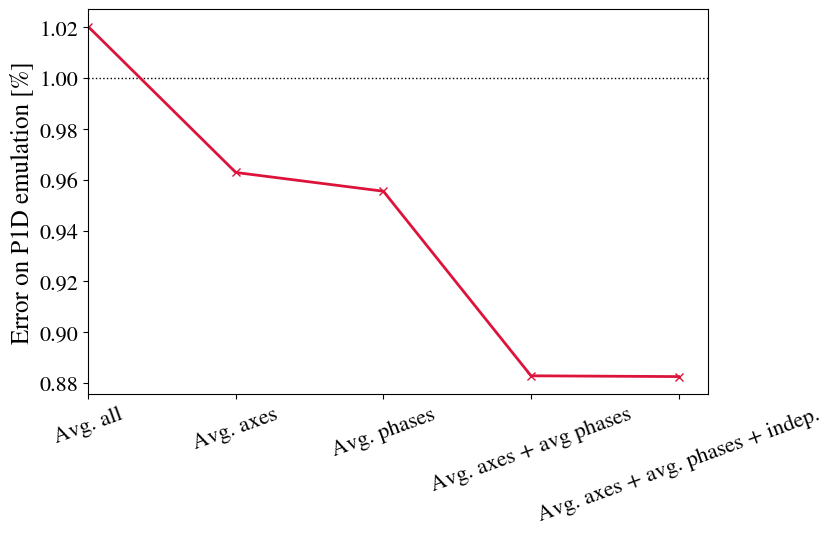

In [28]:
plt.figure(figsize = (8,5))


plt.yticks(fontsize = 16)
plt.xticks(rotation =20, fontsize = 16)

plt.ylabel('Error on P1D emulation [%]', fontsize = 18)

plt.axhline(y =1, color = 'black', lw = 1, ls=':')
#plt.axhline(y =sigma68(fractional_error_1axis.flatten()), color = 'navy', lw = 1, ls='--', label = 'Train and test on one axis')
#plt.axhline(y =sigma68(fractional_error_1a_3a.flatten()), color = 'navy', lw = 1, ls='-', label = 'Train o one axis and test on three axes')


plt.plot(labels, errs, marker = 'x', color = 'crimson', ls = '-', lw = 2)






#info_text = r'A=$P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$\nB=$\log P^\prime_{\rm 1D}=\sum_i \alpha_i \cdot \log k$\nC= LeakyReLU\nD= Param. space shift'
#info_text = info_text.replace(r'\n', '\n')
#info_text = 'A = Polyfit-log\nB = log(P1D)\nC = LeakyReLU\nD = Param. space shift'
#plt.text(0.62, 0.57, info_text, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize = 14)


plt.xlim(0,4.2)
#plt.legend(fontsize=12, loc = 6)
#plt.yscale('log')


plt.savefig('net_characterisation_axes.pdf', bbox_inches = 'tight')